In [1]:
ATTR_NOW = 'avg_humidity'

In [2]:
attr_dict = {
    'min_temp': ('mnt', '(a) minimum temperature'),
    'max_temp': ('mxt', '(b) maksimum temperature'),
    'avg_temp': ('avgt', '(c) average temperature'),
    'avg_humidity': ('hum', '(d) humidity'),
    'sunshine': ('sun', '(e) sunshine'),
    'rainfall': ('rain', '(f) rainfall'),
}

ATTR_CODE = attr_dict[ATTR_NOW][0]
ATTR_NAME = attr_dict[ATTR_NOW][1]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima, ndiffs, nsdiffs

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pickle

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../attributes_dataset/humidity.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.head()

,avg_humidity
date,
2018-01-01,87.5
2018-01-02,94.0
2018-01-03,94.0
2018-01-04,88.0
2018-01-05,89.0


# Splitting Data

In [6]:
train_ratio = int(len(df) * 0.9)

In [7]:
dtrain = df.iloc[:train_ratio]
dtest = df.iloc[train_ratio:]

In [8]:
print(dtrain.shape)
print(dtest.shape)

(1395, 1)
(156, 1)


# Visualisasi ACF dan PACF

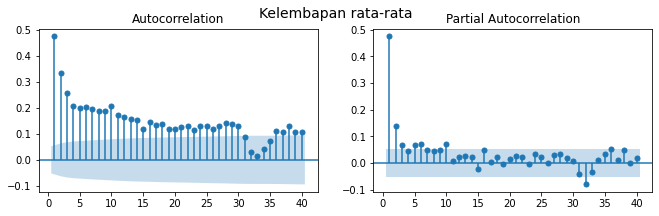

In [9]:
lags = 40
fig, ax = plt.subplots(1,2,figsize=(11,3))
plt.suptitle(ATTR_NAME, fontsize=14)
sgt.plot_acf(dtrain, lags=lags, zero=False, ax=ax[0], 
sgt.plot_pacf(dtrain, lags=lags, zero=False, ax=ax[1])
plt.show()

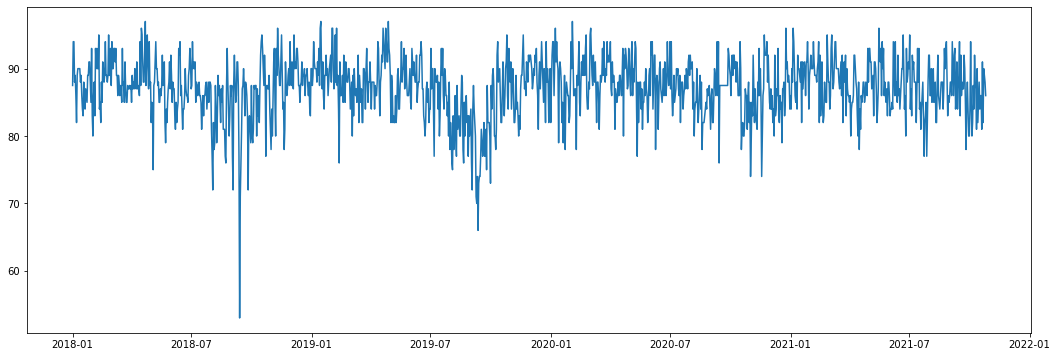

In [10]:
plt.figure(figsize=(18,6))
plt.plot(dtrain)

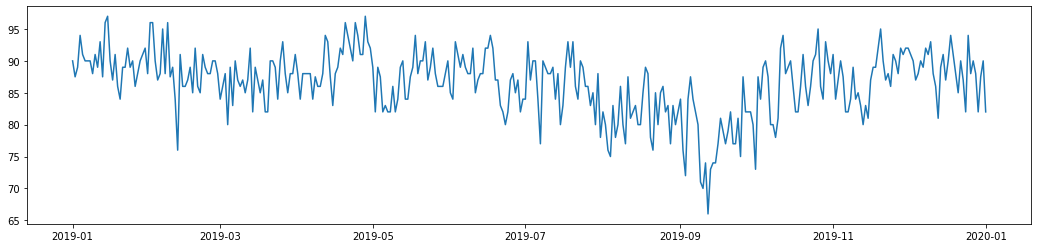

In [11]:
plt.figure(figsize=(18,4))
plt.plot(dtrain.loc['2019-01-01':'2020-01-01'])

In [12]:
dtrain.head(5)

,avg_humidity
date,
2018-01-01,87.5
2018-01-02,94.0
2018-01-03,94.0
2018-01-04,88.0
2018-01-05,89.0


# Stasionary Test (dickey fuller)

In [13]:
adf = sts.adfuller(dtrain)
print(f'ADF p values\t\t: {adf[1]}')
print(f'ADF statistic values\t: {adf[0]}')
print(f'ADF critical values\t: {adf[4]}')

ADF p values		: 2.9630198681566646e-10
ADF statistic values	: -7.161317540117949
ADF critical values	: {'1%': -3.435080296942406, '5%': -2.863629081525758, '10%': -2.567882222497361}


In [14]:
# p-value < 0.05 tidak stasioner
sts.kpss(dtrain, regression='ct')

(0.09231442632516067,
 0.1,
 24,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

### Data stasioner karena p values < 0.05 dan statistic values < 5% critical values  menurut ADF TEST

# Levene Test

In [15]:
len_dtrain = len(dtrain)
levgrp_1 = dtrain.avg_humidity.iloc[int(0.2*len_dtrain):int(0.6*len_dtrain)].values
levgrp_2 = dtrain.avg_humidity.iloc[:int(0.4*len_dtrain)].values
levgrp_3 = dtrain.avg_humidity.iloc[int(0.8*len_dtrain):].values
levgrp_4 = dtrain.avg_humidity.iloc[int(0.2*len_dtrain):int(0.9*len_dtrain)].values

In [16]:
#levene p-value > 0.05 == varian stasioner

levene_val = stats.levene(levgrp_1, levgrp_2, levgrp_3, levgrp_4, center='mean')
print(levene_val)
if levene_val[1] > 0.05:
    print('Varian Stasioner')
else:
    print('Varian Tidak Stasioner')    

LeveneResult(statistic=4.075960309034287, pvalue=0.00673171288399278)
Varian Tidak Stasioner


In [17]:
d_value = ndiffs(dtrain, test='kpss')
d_value

0

### Menurut KPSS test, yang menguji Trend Stationarity.. data sudah stasioner

# Boxcox Transformation

In [18]:
trans = boxcox(dtrain.avg_humidity)
dtrain_trans = trans[0]
trans_lambdas = trans[1]

In [19]:
df_dtrain_trans = dtrain.copy()
df_dtrain_trans.avg_humidity = dtrain_trans

# Auto Arima Model

In [20]:
train_exg = pd.read_csv('../R_resource/humidity_train_exog182.csv')
train_exg = train_exg.drop(columns='Unnamed: 0')

In [21]:
test_exg = pd.read_csv('../R_resource/humidity_test_exog182.csv')
test_exg = test_exg.drop(columns='Unnamed: 0')

In [22]:
print(train_exg.shape)
print(test_exg.shape)

(1395, 364)
(156, 364)


In [23]:
model_loc = f'ARIMA_models/{ATTR_NOW}.pkl'

In [24]:
## open the model

with open(model_loc, 'rb') as pkl:
    model = pickle.load(pkl)

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1395
Model:               SARIMAX(4, 0, 6)   Log Likelihood              -28748.196
Date:                Mon, 08 Aug 2022   AIC                          58248.393
Time:                        14:11:25   BIC                          60218.877
Sample:                             0   HQIC                         58985.135
                               - 1395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.271e+08   2.01e-08   1.13e+16      0.000    2.27e+08    2.27e+08
S1-365      1.646e+08   5.88e-10    2.8e+17      0.000    1.65e+08    1.65e+08
C1-365     -4.945e+07   1.45e-08  -3.42e+15      0.000   -4.95e+07   -4.95e+07
S2-365      6.213e+07   8.62e-10    7.2e+16      0.000    6.21e+07    6.21e+07
C2-365     -1.384e+07   1.55e-08  -8.91e+14      0.000   -1.38e+07   -1.38e+07
S3-365      7.997e+07   4.06e-09   1.97e+16      0.000       8e+07       8e+07
C3-365     -9.827e+06   1.55e-08  -6.36e+14      0.000   -9.83e+06   -9.83e+06
S4-365      4.372e+07   1.64e-09   2.66e+16      0.000    4.37e+07    4.37e+07
C4-365       3.96e+07   5.31e-09   7.45e+15      0.000    3.96e+07    3.96e+07
S5-365     -1.058e+07   4.74e-09  -2.23e+15      0.000   -1.06e+07   -1.06e+07
C5-365     -4.617e+06   5.48e-09  -8.42e+14      0.000   -4.62e+06   -4.62e+06
S6-365     -6.358e+06   4.63e-09  -1.37e+15      0.000   -6.36e+06   -6.36e+06
C6-365      4.145e+06   2.07e-09   2.01e+15      0.000    4.15e+06    4.15e+06
S7-365      3.373e+07   1.03e-08   3.28e+15      0.000    3.37e+07    3.37e+07
C7-365      -3.58e+07   4.77e-09  -7.51e+15      0.000   -3.58e+07   -3.58e+07
S8-365      5.578e+07    1.4e-08   3.97e+15      0.000    5.58e+07    5.58e+07
C8-365     -1.846e+07   3.78e-09  -4.89e+15      0.000   -1.85e+07   -1.85e+07
S9-365      2.626e+07   7.63e-09   3.44e+15      0.000    2.63e+07    2.63e+07
C9-365      2.821e+07    3.7e-09   7.63e+15      0.000    2.82e+07    2.82e+07
S10-365     2.118e+07   1.35e-09   1.57e+16      0.000    2.12e+07    2.12e+07
C10-365     3.505e+07   2.73e-09   1.28e+16      0.000    3.51e+07    3.51e+07
S11-365     3.609e+06   2.46e-09   1.47e+15      0.000    3.61e+06    3.61e+06
C11-365     3.006e+06   4.34e-10   6.92e+15      0.000    3.01e+06    3.01e+06
S12-365     8.544e+06   2.62e-09   3.27e+15      0.000    8.54e+06    8.54e+06
C12-365     7.922e+06    1.1e-09   7.19e+15      0.000    7.92e+06    7.92e+06
S13-365     3.117e+07    4.4e-10   7.09e+16      0.000    3.12e+07    3.12e+07
C13-365     2.627e+06   8.88e-09   2.96e+14      0.000    2.63e+06    2.63e+06
S14-365     4.381e+07   4.66e-09    9.4e+15      0.000    4.38e+07    4.38e+07
C14-365    -6.876e+06   3.45e-09  -1.99e+15      0.000   -6.88e+06   -6.88e+06
S15-365     8.972e+05   1.02e-08   8.76e+13      0.000    8.97e+05    8.97e+05
C15-365    -1.672e+07   8.44e-10  -1.98e+16      0.000   -1.67e+07   -1.67e+07
S16-365      3.07e+06   3.69e-09   8.31e+14      0.000    3.07e+06    3.07e+06
C16-365     3.396e+06   4.77e-10   7.12e+15      0.000     3.4e+06     3.4e+06
S17-365     4.538e+06   8.95e-09   5.07e+14      0.000    4.54e+06    4.54e+06
C17-365    -2.443e+07   2.87e-09  -8.52e+15      0.000   -2.44e+07   -2.44e+07
S18-365      9.09e+06   2.89e-09   3.14e+15      0.000    9.09e+06    9.09e+06
C18-365    -6.118e+06   3.99e-09  -1.53e+15      0.000   -6.12e+06   -6.12e+06
S19-365     8.447e+06   4.21e-09   2.01e+15      0.000    8.45e+06    8.45e+06
C1

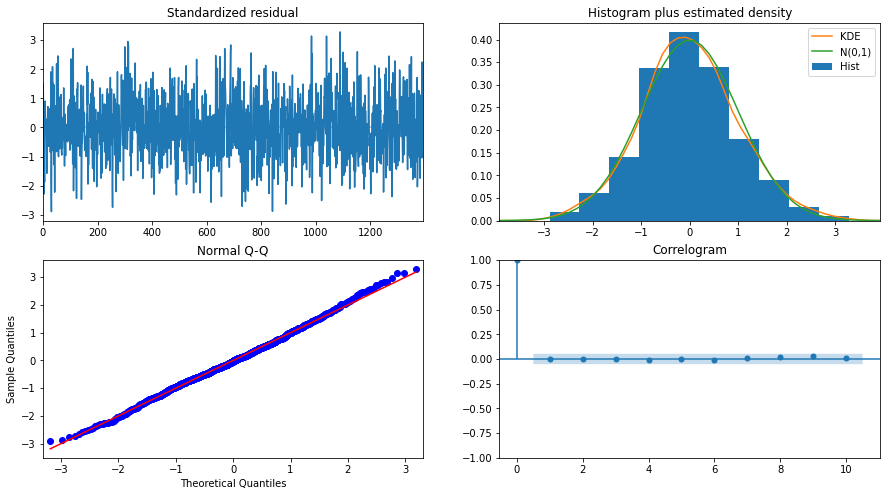

In [26]:
model.plot_diagnostics(figsize=(15,8));

In [27]:
def execute_forecast(pred, df_actual):
    results = pd.DataFrame(data={'date': df_actual.index, 'Predictions': pred, 'Actuals': df_actual[ATTR_NOW].values})
    results.set_index('date', inplace=True)
    
    plt.figure(figsize=(18,8))
    plt.title(f'Peramalan {ATTR_NAME} ARIMA')
    plt.plot(results.Predictions, 'b', label='Predictions')
    plt.plot(results.Actuals, 'r--', label='Actuals')
    plt.legend()
    plt.show
    
    MAE = mean_absolute_error(results.Actuals, results.Predictions)
    RMSE = sqrt(mean_squared_error(results.Actuals, results.Predictions))
    print(f'Mean Absolute Error is\t\t: {MAE}')
    print(f'Root Mean Squared Error is\t: {RMSE}')
    
    return results, MAE, RMSE

In [28]:
predictions = model.predict(n_periods = len(dtest), exogenous=test_exg)

In [29]:
predictions_inv = inv_boxcox(predictions, trans_lambdas)

Mean Absolute Error is		: 4.450978013232235
Root Mean Squared Error is	: 5.766191352576948


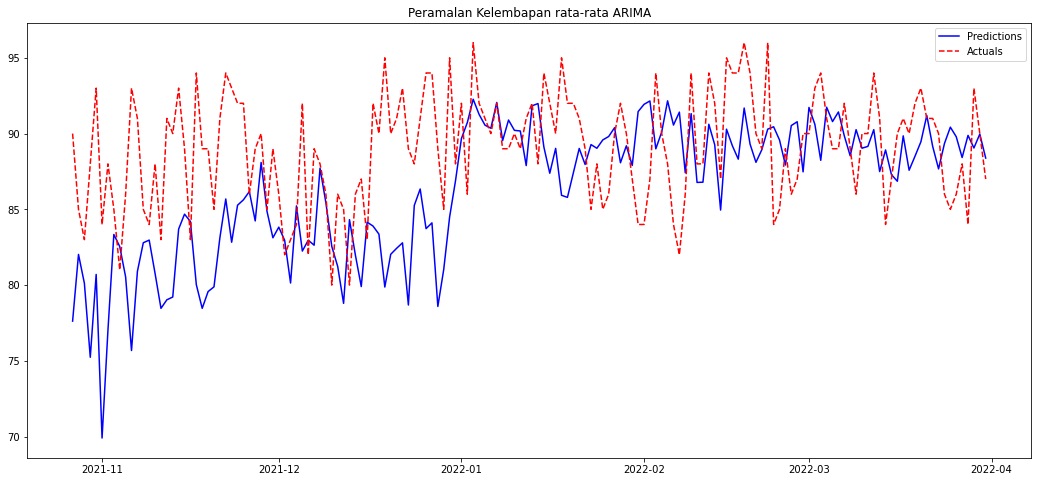

In [30]:
results, __, __ = execute_forecast(predictions_inv, dtest)

# Period Forecasting

In [31]:
def period_forecast(model_loc, period, data, exog):
    with open(model_loc, 'rb') as pkl:
        model = pickle.load(pkl) 
    predictions = []
    prog_count = 0
    for index in np.arange(0, len(data), period):
        if index+period > len(data) - 1:
            period = int(len(data) - index)
        print(f'Forecasting {period}-step from index {index}')
        results = model.predict(n_periods=period, exogenous=exog.iloc[index:index+period])
        for result in results:
            prog_count += 1
            predictions.append(result)
            print(f"result: {result}\t\tprocess: {prog_count}/{len(data)}")
        print('Updating the model...')
        model.update(data.iloc[index:index+period], exogenous=exog.iloc[index:index+period])
            
    return np.array(predictions)

In [32]:
test_trans = boxcox(dtest[ATTR_NOW], lmbda=trans_lambdas)
df_dtest_trans = dtest.copy()
df_dtest_trans[ATTR_NOW] = test_trans

### Forecast scenario 1 : 1 time step

In [33]:
%%time
sc1_forecast = period_forecast(model_loc, 1, df_dtest_trans, test_exg)

Forecasting 1-step from index 0
result: 645284012.6943545		process: 1/156
Updating the model...
Forecasting 1-step from index 1
result: 1127639888.1269531		process: 2/156
Updating the model...
Forecasting 1-step from index 2
result: 918103591.3573129		process: 3/156
Updating the model...
Forecasting 1-step from index 3
result: 641618685.269424		process: 4/156
Updating the model...
Forecasting 1-step from index 4
result: 1078691149.0247545		process: 5/156
Updating the model...
Forecasting 1-step from index 5
result: 818461730.2950587		process: 6/156
Updating the model...
Forecasting 1-step from index 6
result: 1023901392.2343473		process: 7/156
Updating the model...
Forecasting 1-step from index 7
result: 1292301381.5331366		process: 8/156
Updating the model...
Forecasting 1-step from index 8
result: 1058983206.6740859		process: 9/156
Updating the model...
Forecasting 1-step from index 9
result: 878172912.215142		process: 10/156
Updating the model...
Forecasting 1-step from index 10
res

Forecasting 1-step from index 84
result: 1377471759.2551756		process: 85/156
Updating the model...
Forecasting 1-step from index 85
result: 1472691366.131702		process: 86/156
Updating the model...
Forecasting 1-step from index 86
result: 1527086748.2384176		process: 87/156
Updating the model...
Forecasting 1-step from index 87
result: 1387028945.369917		process: 88/156
Updating the model...
Forecasting 1-step from index 88
result: 1424587922.1533308		process: 89/156
Updating the model...
Forecasting 1-step from index 89
result: 1270712647.8772383		process: 90/156
Updating the model...
Forecasting 1-step from index 90
result: 1339323586.64087		process: 91/156
Updating the model...
Forecasting 1-step from index 91
result: 1273271327.350829		process: 92/156
Updating the model...
Forecasting 1-step from index 92
result: 1279130685.236438		process: 93/156
Updating the model...
Forecasting 1-step from index 93
result: 1203929386.0621173		process: 94/156
Updating the model...
Forecasting 1-st

In [34]:
sc1_forecast_inv = inv_boxcox(sc1_forecast, trans_lambdas)

Mean Absolute Error is		: 3.3843074662308177
Root Mean Squared Error is	: 4.182789617426787


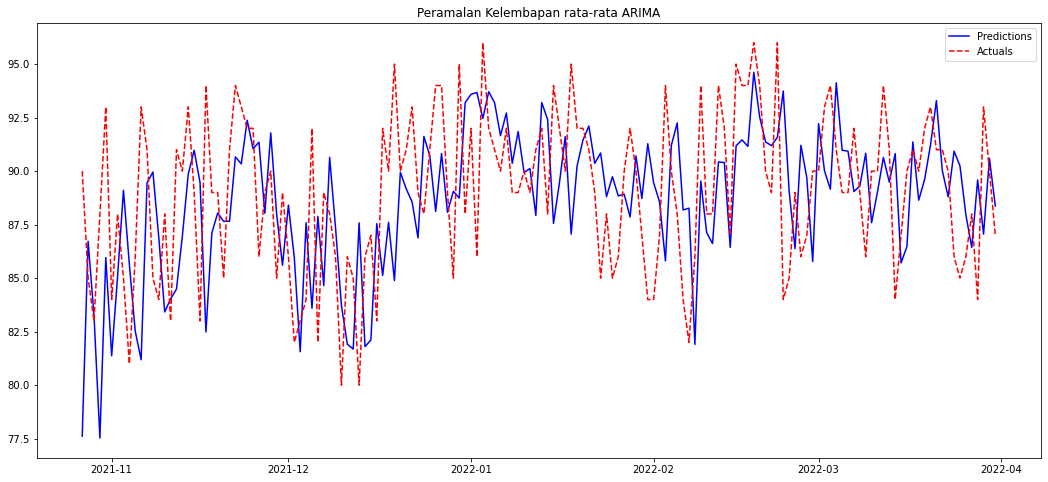

In [35]:
sc1_forecast_df, __, __ = execute_forecast(sc1_forecast_inv, dtest)

### Forecast scenario 2 : 3 time step

In [36]:
%%time
sc2_forecast = period_forecast(model_loc, 3, df_dtest_trans, test_exg)

Forecasting 3-step from index 0
result: 645284012.6943545		process: 1/156
result: 851914989.2434726		process: 2/156
result: 756893595.5873115		process: 3/156
Updating the model...
Forecasting 3-step from index 3
result: 642077981.406435		process: 4/156
result: 858650375.8907768		process: 5/156
result: 454132892.0247766		process: 6/156
Updating the model...
Forecasting 3-step from index 6
result: 1023003465.195596		process: 7/156
result: 1216405838.525743		process: 8/156
result: 1111877753.2865117		process: 9/156
Updating the model...
Forecasting 3-step from index 9
result: 877366845.6048788		process: 10/156
result: 728546267.8801426		process: 11/156
result: 948963390.3799882		process: 12/156
Updating the model...
Forecasting 3-step from index 12
result: 1354058820.0009437		process: 13/156
result: 1271734233.1682		process: 14/156
result: 1093410284.9276073		process: 15/156
Updating the model...
Forecasting 3-step from index 15
result: 960301341.4736807		process: 16/156
result: 101099135

Forecasting 3-step from index 132
result: 1305204341.5018897		process: 133/156
result: 1432672752.113314		process: 134/156
result: 1325663255.0964172		process: 135/156
Updating the model...
Forecasting 3-step from index 135
result: 1285848006.1302507		process: 136/156
result: 1378360447.511353		process: 137/156
result: 1191783041.0673423		process: 138/156
Updating the model...
Forecasting 3-step from index 138
result: 1422933644.2964182		process: 139/156
result: 1241785852.737538		process: 140/156
result: 1208253931.198971		process: 141/156
Updating the model...
Forecasting 3-step from index 141
result: 1464952944.6642163		process: 142/156
result: 1270608593.7606118		process: 143/156
result: 1300810426.4360154		process: 144/156
Updating the model...
Forecasting 3-step from index 144
result: 1453423638.8403523		process: 145/156
result: 1569874922.2147725		process: 146/156
result: 1395240052.8490145		process: 147/156
Updating the model...
Forecasting 3-step from index 147
result: 1270857

In [37]:
sc2_forecast_inv = inv_boxcox(sc2_forecast, trans_lambdas)

Mean Absolute Error is		: 3.6882805430742396
Root Mean Squared Error is	: 4.616743376822485


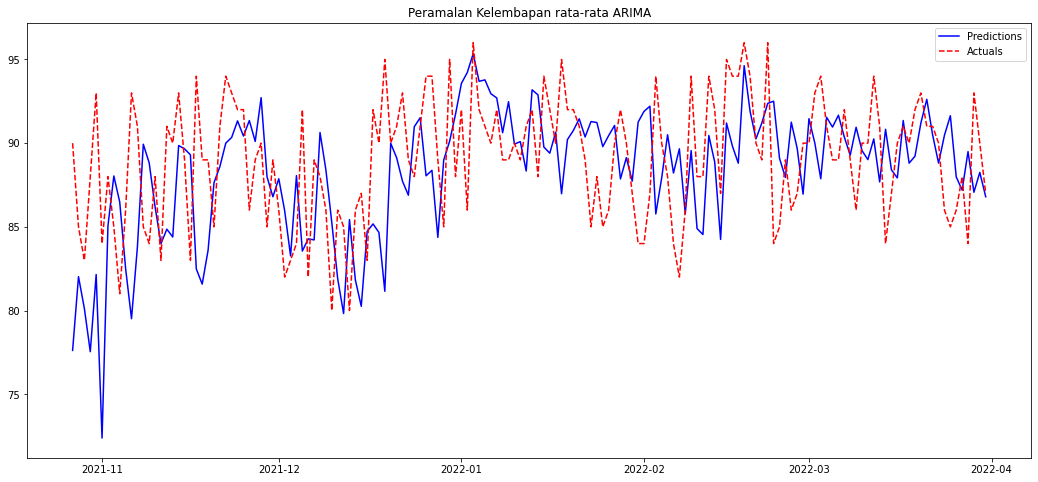

In [38]:
sc2_forecast_df, __, __ = execute_forecast(sc2_forecast_inv, dtest)

### Forecast scenario 3 : 7 time step

In [39]:
%%time
sc3_forecast = period_forecast(model_loc, 7, df_dtest_trans, test_exg)

Forecasting 7-step from index 0
result: 645284012.6943545		process: 1/156
result: 851914989.2434726		process: 2/156
result: 756893595.5873113		process: 3/156
result: 551556146.1582783		process: 4/156
result: 785111179.6386535		process: 5/156
result: 381008975.81610835		process: 6/156
result: 620807692.722045		process: 7/156
Updating the model...
Forecasting 7-step from index 7
result: 1290834083.2050066		process: 8/156
result: 1166191664.6073637		process: 9/156
result: 1058658194.0326942		process: 10/156
result: 853788458.6959383		process: 11/156
result: 1035705064.3824645		process: 12/156
result: 1118368580.1353574		process: 13/156
result: 1142797227.4036384		process: 14/156
Updating the model...
Forecasting 7-step from index 14
result: 927486395.7133849		process: 15/156
result: 845934514.9015688		process: 16/156
result: 930678126.04208		process: 17/156
result: 931913005.8304336		process: 18/156
result: 1108050058.4318767		process: 19/156
result: 1162998148.5414553		process: 20/156
re

In [40]:
sc3_forecast_inv = inv_boxcox(sc3_forecast, trans_lambdas)

Mean Absolute Error is		: 3.994293518958923
Root Mean Squared Error is	: 4.970984064344016


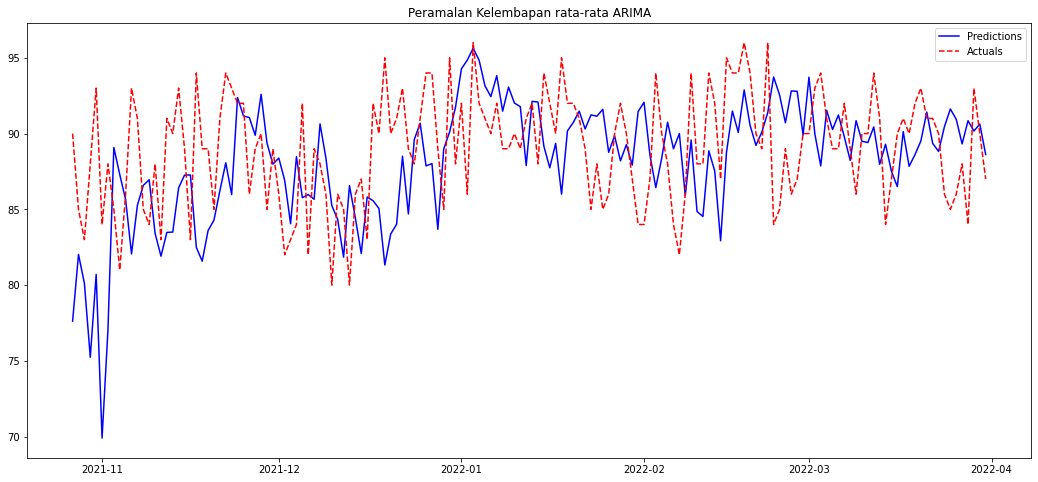

In [41]:
sc3_forecast_df, __, __ = execute_forecast(sc3_forecast_inv, dtest)

# Collecting All Predictions Scenario Result

In [42]:
def plot_forecasts_result(res_df):
    title = 'Peramalan ' + ATTR_NAME + ' ARIMA'
    
    plt.figure(figsize=(18,8))
    plt.title(title)
    plt.plot(res_df['scn-1'], 'r-', label='1-step forecast')
    plt.plot(res_df['scn-2'], 'b-', label='3-step forecast')
    plt.plot(res_df['scn-3'], 'g-', label='7-step forecast')
    plt.plot(res_df['Actuals'], color='black', linestyle=':' , label='Actuals')
    plt.legend()

In [43]:
def col_forcasts_err(res_df):
    for col in [x for x in range(len(forecasts_result.columns)-1)]:
        col_name = res_df.columns[col]
        MAE = mean_absolute_error(res_df['Actuals'], res_df[col_name])
        RMSE = sqrt(mean_squared_error(res_df['Actuals'], res_df[col_name]))
        print('Error for ', col_name)
        print(f'Mean Absolute Error is\t\t: {MAE}')
        print(f'Root Mean Squared Error is\t: {RMSE}')
        print()

In [44]:
sc1_df_cp = sc1_forecast_df.copy()
sc1_df_cp.columns = ['scn-1', 'Actuals']

sc2_df_cp = sc2_forecast_df.copy()
sc2_df_cp.columns = ['scn-2', 'Actuals']

sc3_df_cp = sc3_forecast_df.copy()
sc3_df_cp.columns = ['scn-3', 'Actuals']

In [45]:
forecasts_result = pd.concat([sc1_df_cp[[sc1_df_cp.columns[0]]],
                              sc2_df_cp[[sc2_df_cp.columns[0]]],
                              sc3_df_cp[[sc3_df_cp.columns[0]]],
                              sc1_df_cp[[sc3_df_cp.columns[1]]]
                             ],
                               axis='columns')

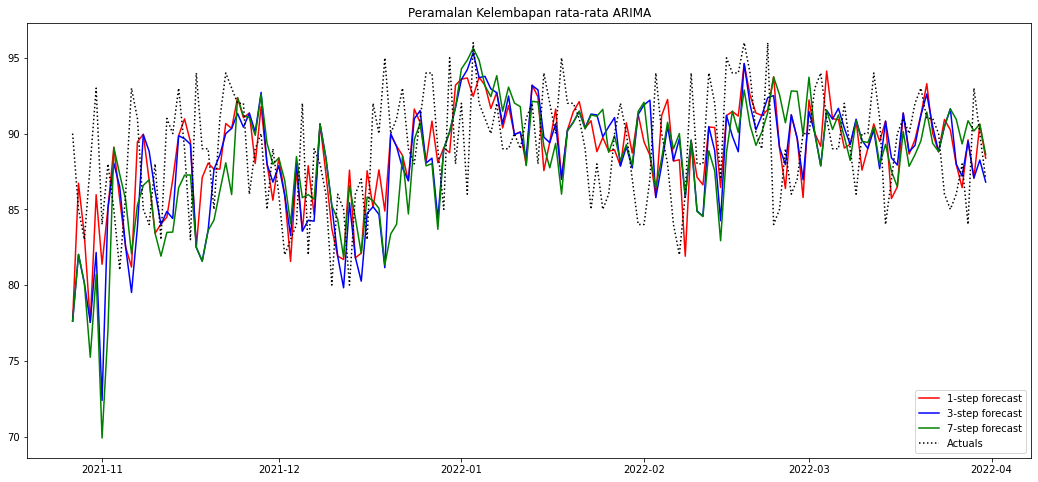

In [46]:
plot_forecasts_result(forecasts_result)

In [47]:
col_forcasts_err(forecasts_result)

Error for  scn-1
Mean Absolute Error is		: 3.3843074662308177
Root Mean Squared Error is	: 4.182789617426787

Error for  scn-2
Mean Absolute Error is		: 3.6882805430742396
Root Mean Squared Error is	: 4.616743376822485

Error for  scn-3
Mean Absolute Error is		: 3.994293518958923
Root Mean Squared Error is	: 4.970984064344016



## Saving forecasts result

In [48]:
forecasts_result.to_csv('ARIMA_results/'+ATTR_NOW+'.csv')